<a href="https://colab.research.google.com/github/jp-ishimwe/Projects/blob/master/Wheat_rust_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

Wheat rust is a devastating plant disease that affects many African crops, reducing yields and affecting the livelihoods of farmers and decreasing food security across the continent. The disease is difficult to monitor at a large scale, making it difficult to control and eradicate. The wheat can have stem rust, leaf rust or be healthy. If we can have an algorithm that can detect wheat rust from any image will enable a crowd-sourced approach to monitoring African crops, through avenues such as social media and smartphone images. Through this image recognition model we can monitor this plant diseases like wheat rust that affect African livelihoods.  

### Objective

The objective of this task is to build a machine learning algorithm to correctly classify if a plant is healthy, has stem rust, or has leaf rust.

### Datasets

The dataset used here collected from Zindi webpage where the bulk of the data was collected in-field by CIMMYT and CIMMYT partners in Ethiopia and Tanzania. The remainder of the data was sourced from public images found on Google Images.

There are $876$ images to train the model on from which we can split for validation (train file contains three folders: healthy_wheat, leaf_rust, stem_rust) and $610$ images in the test set by which we will use to generate their wheat rust categories.

Some images may contain both stem and leaf rust, there is always one type of rust that is more dominant than the other, i.e. you can not find images where both appear equally. Then the goal should to classify the image according to the type of wheat rust that appears most prominently in the image. 

### Importing packages

In [0]:
import time
import os
import gzip
import matplotlib.image as img
from skimage import io
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
from PIL import Image
import copy

import torch
from torchvision import  datasets, transforms
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.optim as scheduler

In [0]:
CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")
print(device)

cuda


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Loading and Unzipping Datasets



*   Unzip datasets



In [0]:
!unzip -q '/content/drive/My Drive/test.zip'
!unzip -q '/content/drive/My Drive/train.zip'

In [0]:
te= '/content/test'
tr = '/content/train'

*   Creating helper functions

In [0]:
class CustomDataLoader(Dataset):

  '''
  class for loading test dataset
  -----
  Returns image and its corresponding index  
  '''

  def __init__(self, root_dir, transform = None):
    self.root_dir = root_dir
    self.transform = transform
    self.filenames = os.listdir(root_dir) # Root dir of images
    self.filenames.sort()

  def __len__(self):
      return len(self.filenames)

  def __getitem__(self, idx):
      if torch.is_tensor(idx):
          idx = idx.tolist()
      file_name = self.filenames[idx]
      ind = file_name.split('.')
      index = ind[0]

      img_name = os.path.join(self.root_dir,file_name)
      image = io.imread(img_name)
      
      if self.transform:
          image = self.transform(image)
    
      return index, image


In [0]:
class TrainDataLoader(Dataset):
    def __init__(self, root_dir, transform = None):
      
      '''
      Datasetloader with subforders, it needs the Root dir of images file and Transform, which is set to None by
      default.
      '''
      """
      Returns:
        - The image
        - The image class label
      """
      self.folders = os.listdir(root_dir)
      self.root_dir = root_dir
      self.transform = transform
      self.file_list = []
    
      for folder in self.folders:
        files = os.listdir(os.path.join(self.root_dir, folder))
        for file in files:
          self.file_list.append((file, self.folders.index(folder)))            
    def __len__(self):
        return len(self.file_list)  

    def __getitem__(self, idx):
      if torch.is_tensor(idx):
          idx = idx.tolist()
      file_names = [self.root_dir  + '/'+ self.folders[folder[1]]+'/' + folder[0] for folder in self.file_list]

      img, label = Image.open(os.path.join(self.root_dir , file_names[idx])).convert('RGB'),self.file_list[idx][1]
      if self.transform:
          img = self.transform(img)
      return img, label

In [0]:
def train_validation_split(training_data,validation, random_seed=42, val_train_split=0.2, shuffle=False):
  '''
  Function to split into train and validation datasets

  -----
  Returns:
    - iterable training & validation datasets,
    - training and validation sizes  
  '''
      
    len_train = len(training_data)
    indices = list(range(len_train))
    split = int(np.floor(val_train_split * len_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_indx, valid_indx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_indx)
    valid_sampler = SubsetRandomSampler(valid_indx)

    Len_train = len(train_sampler)
    Len_val = len(valid_sampler)

    train_loader = torch.utils.data.DataLoader(training_data, batch_size=16, sampler= train_sampler, shuffle=False, num_workers=4)
    valid_loader = torch.utils.data.DataLoader(validation, batch_size=16, sampler= valid_sampler, shuffle=False, num_workers=4)
    

    return train_loader, valid_loader, Len_train, Len_val

### Train, validation, Dev datasets split

In [0]:
# Required normalization for pretrained models, we use standard normilization
# transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
       

transform_train = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

transform_valid = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

transform_test = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

training_data = TrainDataLoader(tr, transform=transform_train)
validation_data = TrainDataLoader(tr, transform=transform_valid)
testing_data = CustomDataLoader(te, transform=transform_test)

train_loader, valid_loader, Len_train, Len_val = train_validation_split(training_data,
                                                                        validation_data,
                                                                        random_seed=42, 
                                                                        val_train_split=0.2, 
                                                                        shuffle=True)

test_loader = torch.utils.data.DataLoader(testing_data, batch_size=16, shuffle=True, num_workers=4)

In [0]:
images, labels = next(iter(train_loader))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


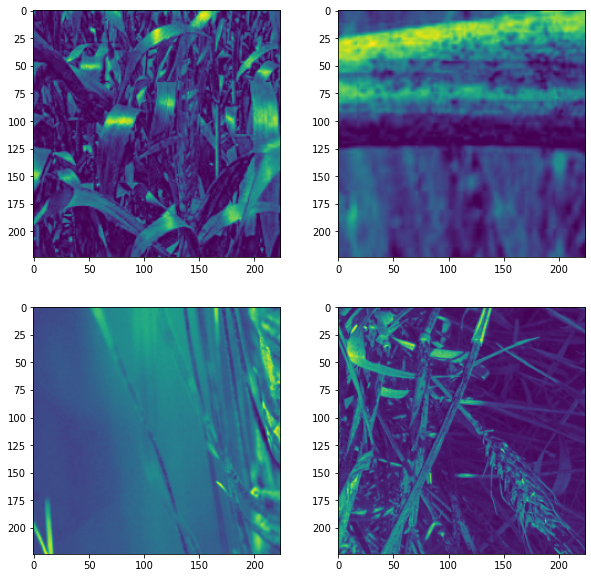

In [0]:
plt.subplots(figsize=(10,10), ncols=2)
for i in range(4):
    for j in range(3):
        plt.subplot(2, 2, i + 1)
        plt.imshow(images[i][j].squeeze().numpy())

## Loading **pre-trained Models**

Under this task we are going to Resnet50 network, for classifying the three diseases in the agriculture

---



In [0]:
def choose_model(model_name=None):
  n_classes = 3
  # Chunking off the last layer and 
  # creating our output fc connected layer
  #Vgg19.classifier.
  from collections import OrderedDict

  if model_name == 'vgg':

    model = models.vgg19(pretrained=True)

    for layer_params in model.parameters():
      layer_params.requires_grad = False

    in_features = model.classifier[6].in_features # 4096
    model.classifier[6] = nn.Sequential(
                        nn.Linear(in_features, in_features), 
                        nn.ReLU(), 
                        nn.Dropout(0.4, inplace=False),
                        nn.Linear(in_features, n_classes),                   
                        nn.LogSoftmax(dim=1)
                        )
    model = model.to(device)

  else:
    model = models.resnet50(pretrained=True)

    # for param in model.parameters():
    #   param.requires_grad = False

    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
                    nn.Linear(num_ftrs, num_ftrs),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.5),
                    nn.Linear(num_ftrs, n_classes),                   
                    nn.LogSoftmax(dim=1))

    model = model.to(device)

  return model

In [0]:
model = choose_model()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Optimizer and Criterion

In [0]:
#Optimization
learning_rate = 1e-3
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# Decay LR by a factor of 0.1 every 9 epochs
lr_schedule = scheduler.lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.1)#5

### Model training and Evaluation

In [0]:
def train_classifier(model, train_loader,valid_loader,learning_rate = 1e-3, num_epochs=27):
  
  histories = []
  start= time.time()

  best_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('**'*7)

    model.train()
    
    train_loss = 0
    train_acc = 0

    valid_loss = 0
    valid_acc = 0

    ###################################### START TRAINING #############################
    #Training the model per epoch#

    for batch_idx, (data, labels) in enumerate(train_loader):
      data = data.to(device)
      labels = labels.to(device)

      # start training
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, labels)
      loss.backward()

      optimizer.step()

      _,pred = output.data.max(1, keepdim=True)# or torch.max(output, 1)
      correct_class = pred.eq(labels.data.view_as(pred)).cpu().sum().item() #or torch.sum(pred == labels.data)        
      train_loss += loss.item() * data.size(0)
      train_acc += correct_class

    train_loss = train_loss/Len_train
    train_acc = train_acc/Len_train
    lr_schedule.step()

    ###################################### START EVALUATION #############################
    #Evaluating the model performance per epoch#

    with torch.no_grad():
      model.eval()

      for datas, label in valid_loader:
        datas = datas.to(device)
        label = label.to(device)
        out = model(datas)
        val_loss = criterion(out, label)

        _,preds = out.data.max(1, keepdim =True) #torch.max(out, 1)
        correct =  preds.eq(label.data.view_as(preds)).cpu().sum().item()#torch.sum(preds == label.data)        
        valid_loss += val_loss.item() * datas.size(0)
        valid_acc += correct
    valid_loss = valid_loss/Len_val
    valid_acc = valid_acc/Len_val # or on the values of acc double()

    if valid_acc > best_acc:
      best_acc = valid_acc
      best_wts = copy.deepcopy(model.state_dict())

    histories.append([train_loss,valid_loss, train_acc, valid_acc])
    
    print('Training accuracy: {:.3f}, train loss: {:.4f}'.format(train_acc*100, train_loss), end='\n')
    print('Validation accuracy: {:.3f}, valid loss: {:.4f}'.format(valid_acc*100, valid_loss), end='\n')
    
    print()

  time_elapsed = time.time() - start
  print('\nTraining complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
  print('The best model accuracy {:.3f}'.format(best_acc))

  
  model.load_state_dict(best_wts)

  return model, histories

In [0]:
model_fit, histories = train_classifier(model, train_loader, valid_loader,learning_rate = 1e-3, num_epochs=27)

Epoch 0/26
**************
Training accuracy: 45.792, train loss: 0.9902
Validation accuracy: 52.000, valid loss: 0.8842

Epoch 1/26
**************
Training accuracy: 67.475, train loss: 0.7631
Validation accuracy: 77.143, valid loss: 0.6261

Epoch 2/26
**************
Training accuracy: 75.606, train loss: 0.5872
Validation accuracy: 83.429, valid loss: 0.4373

Epoch 3/26
**************
Training accuracy: 82.311, train loss: 0.4656
Validation accuracy: 84.000, valid loss: 0.3662

Epoch 4/26
**************
Training accuracy: 85.592, train loss: 0.3906
Validation accuracy: 88.000, valid loss: 0.3113

Epoch 5/26
**************
Training accuracy: 85.307, train loss: 0.3832
Validation accuracy: 87.429, valid loss: 0.3207

Epoch 6/26
**************
Training accuracy: 86.591, train loss: 0.3583
Validation accuracy: 92.000, valid loss: 0.2475

Epoch 7/26
**************
Training accuracy: 87.019, train loss: 0.3666
Validation accuracy: 90.286, valid loss: 0.2354

Epoch 8/26
**************
Traini

### Performance Evaluation

In [0]:
s = np.array(histories)

In [0]:
train_losses = s[:,0]
test_losses = s[:,1]

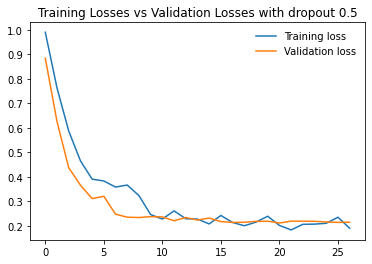

In [0]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.title("Training Losses vs Validation Losses with dropout 0.5")
plt.show()

We can see that the model performance from the above figure is really performing well.

### Saving the model

In [0]:
path = '/content/drive/My Drive/last_best_model_res50.pth'
torch.save(model_fit.state_dict(),path)

### Using model for prediction on dev datasets

In [0]:
def evaluation(model, test_loader):
  model.eval()
  pred ={'ID':[], 'classes':[]}
  with torch.no_grad():
    for i, (index, data) in tqdm(enumerate(test_loader)):
      data = data.to(device)
      output = model(data)
      prob = torch.exp(output)
      pred['ID'].append(index)
      pred['classes'].append(prob.data.cpu().numpy())
   
  return pred

In [0]:
pred = evaluation(model_fit, test_loader)

39it [01:45,  2.70s/it]


In [0]:
indices = pred['ID']
clas = pred['classes']
sz = len(test_loader.dataset)

In [0]:
indx = [] # a list
for v in indices:
  val = list(v)
  for e in val:
    indx.append(e)

In [0]:
classes = [] # a list
for i in range(len(clas)):
  val = clas[i]
  for v in val:
    classes.append(v)

In [0]:
proba = np.array(classes)
indexes = np.array(indx)

d = pd.DataFrame(proba)
e = pd.DataFrame(indexes)

In [0]:
subm = pd.concat([e, d], axis=1)
subm.columns = ['ID'] +  training_data.folders #training_data.folders 

### Saving predictions in .csv format.

In [0]:
pas = '/content/drive/My Drive/sample_submission.csv'
subm.to_csv(pas,sep=',')